### **Load libraries**

In [1]:
import sys
sys.path.append('../src')
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import risk_kit as rk
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout
import importlib

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.api import VAR
from mgarch import mgarch

import itertools
import random

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

### **Load data**

In [4]:
rets = pd.read_csv('all_rets.csv', index_col=0)
stocks = pd.read_csv('all_stocks.csv', index_col=0)
selected_stocks = pd.read_csv('selected_stocks_rets.csv', index_col=0).columns

rets.index = pd.to_datetime(rets.index).to_period('W')
stocks.index = pd.to_datetime(stocks.index).to_period('W')

In [5]:
# Define the number of periods per year for all calculations
# 252 is an approximation for daily
# 54 for weekly
# 12 for monthly
periods_per_year = 54

In [6]:
rets_backup = rets.copy(); stocks_backup = stocks.copy()

# Determine the dataset size
# Uncomment if a smaller dataset is desired
# rets = rets.loc['2021-01-01':]
# stocks = stocks.loc['2021-01-01':]

# **Estimation of future Moving Average Returns**

## **Analysis of stationarity**

In [7]:
# Analysis of stationarity for the whole series
for stock in rets.columns:
    print(f'Augmented Dickey Fuller Test p-value for non-stationarity of level {stock} series: {round(adfuller(rets[stock])[1], 4)}')

# All return series are stationary, however, differentiating by first order seems to result in better models

Augmented Dickey Fuller Test p-value for non-stationarity of level BOGOTA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level BVC.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CELSIA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CEMARGOS.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CIBEST.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CNEC.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CONCONCRET.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CORFICOLCF.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level ECOPETROL.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level ENKA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level ETB.CL series: 0.0
Augmented Dickey F

## **Model 1: Annualized Yearly Returns from the Last 3 Years**

In [8]:
# Compare with the expected returns calculated from historical returns
historical_annualized_returns = rk.summary_stats(rets.iloc[-162:], periods_per_year=periods_per_year)['Annualized Return']
historical_annualized_returns

BOGOTA.CL        0.000178
BVC.CL           0.253442
CELSIA.CL        0.181092
CEMARGOS.CL      0.470033
CIBEST.CL        0.333802
CNEC.CL         -0.422407
CONCONCRET.CL    0.205898
CORFICOLCF.CL    0.011686
ECOPETROL.CL     0.123444
ENKA.CL          0.021710
ETB.CL          -0.299242
EXITO.CL         0.018098
GEB.CL           0.307688
GRUBOLIVAR.CL    0.145153
GRUPOARGOS.CL    0.180642
GRUPOAVAL.CL     0.004997
GRUPOSURA.CL     0.101240
HCOLSEL.CL       0.192651
ICOLCAP.CL       0.172435
ISA.CL           0.090474
MINEROS.CL       0.686910
NUTRESA.CL       0.633335
PFAVAL.CL        0.021288
PFCIBEST.CL      0.318413
PFCORFICOL.CL    0.081383
PFDAVVNDA.CL    -0.027116
PFGRUPOARG.CL    0.223164
PFGRUPSURA.CL    0.401319
PROMIGAS.CL      0.111796
TERPEL.CL        0.377302
AAPL             0.152905
AMZN             0.232143
BAC              0.180421
BRK-B            0.207157
C                0.281974
CBU7.L           0.027716
CENCOSUD.SN      0.380075
CHILE.SN         0.244581
CSPX.L      

## **Model 2: VAR bagging**

In [9]:
# Get the 1st order integration for the returns series
rets_integrated = (rets - rets.shift(1)).dropna()

In [10]:
symbols_list = list(rets.columns.values) # List of all available stock symbols
n_iterations = 2000 # The number of iterations of VAR models to perform
set_size = 10 # Number of symbols modeled in each iteration
periods_to_forecast = 4 # Number of periods to forecast

# Initialize an empty list of sets of stock symbols
iterations_symbols = []

for i in range(n_iterations):
    # For each iteration of the model, select a random set of 'set_size' stock symbols
    iterations_symbols.append(random.sample(symbols_list, set_size))

In [11]:
# Initialize a dictionary of dictionaries where the results of each iteration will be stored
prediction_results = {symbol: {} for symbol in symbols_list}

for i, symbols_selection in enumerate(iterations_symbols):
    # In each iteration, generate a dataset with the stocks selected for the iteration only
    subset_df = rets_integrated[symbols_selection]
    
    # Compare the IC (Information Criteria) scores for VAR models of various number of lags to select the ideal number of lags
    varmod = VAR(subset_df)
    lag_sel = varmod.select_order(10)
    
    # Select the best number of lags according to the AIC criterion
    n_lags = lag_sel.aic
    print(f'Iteration {i}, ideal_n_lags: {n_lags}')
    
    # Fit the model for the iteration
    var_model = VAR(subset_df).fit(maxlags=n_lags, trend='c')

    # Predict the following 'periods_to_forecast' periods
    predictions = var_model.forecast(subset_df.iloc[-n_lags:].values, periods_to_forecast)
    predictions = pd.DataFrame(predictions)

    # Append the predicted values to the 'prediction_results' dictionary
    for l in predictions:
        prediction_results[symbols_selection[l]][i] = predictions[l]
    print(f'Iteration {i+1} finished')

Iteration 0, ideal_n_lags: 8
Iteration 1 finished
Iteration 1, ideal_n_lags: 7
Iteration 2 finished
Iteration 2, ideal_n_lags: 8
Iteration 3 finished
Iteration 3, ideal_n_lags: 7
Iteration 4 finished
Iteration 4, ideal_n_lags: 9
Iteration 5 finished
Iteration 5, ideal_n_lags: 9
Iteration 6 finished
Iteration 6, ideal_n_lags: 10
Iteration 7 finished
Iteration 7, ideal_n_lags: 8
Iteration 8 finished
Iteration 8, ideal_n_lags: 8
Iteration 9 finished
Iteration 9, ideal_n_lags: 8
Iteration 10 finished
Iteration 10, ideal_n_lags: 10
Iteration 11 finished
Iteration 11, ideal_n_lags: 6
Iteration 12 finished
Iteration 12, ideal_n_lags: 9
Iteration 13 finished
Iteration 13, ideal_n_lags: 10
Iteration 14 finished
Iteration 14, ideal_n_lags: 10
Iteration 15 finished
Iteration 15, ideal_n_lags: 10
Iteration 16 finished
Iteration 16, ideal_n_lags: 10
Iteration 17 finished
Iteration 17, ideal_n_lags: 7
Iteration 18 finished
Iteration 18, ideal_n_lags: 9
Iteration 19 finished
Iteration 19, ideal_n_lag

In [12]:
import warnings
warnings.filterwarnings('ignore')

# Copy the 'prediction_results' dictionary to invert the integration of the copy and set the index for predicted dates
prediction_results_processed = prediction_results.copy()
for symbol in prediction_results:
    # For each stock in 'prediction_results', convert the predictions into a dataframe
    pred_df = pd.DataFrame(prediction_results[symbol])

    # Get the average predictions for each day
    pred_series = pred_df.mean(axis=1)

    # Invert the integration by taking the last actual returns and add it to the predictions, then do a cumulative sum
    pred_series = rets[symbol][-1] + pred_series.cumsum()
    
    # Generate an index for the future dates
    #future_dates = pd.date_range(start=rets.index.max().to_timestamp() + pd.Timedelta(value=1, unit='d'), periods=periods_to_forecast)
    future_dates = pd.date_range(start=rets.index.max().to_timestamp() + pd.Timedelta(value=7, unit='d'), periods=periods_to_forecast, freq='W-SUN').to_period('W') # Weekly
    pred_series.index = future_dates
    
    # Add the series of average predicted returns for the stock to the 'prediction_results_processed' dictionary
    prediction_results_processed[symbol] = pred_series

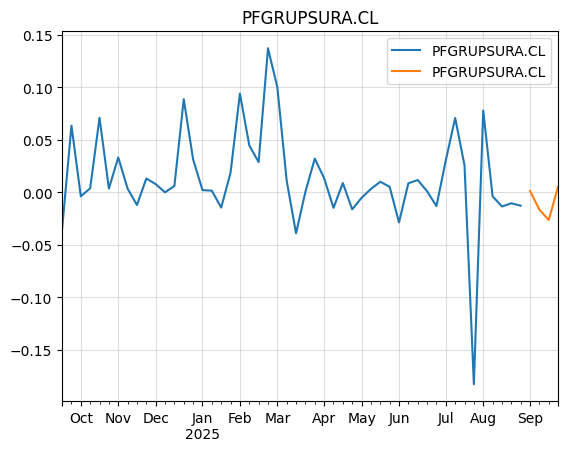

In [13]:
# Visualize the predictions of any stock
symbol = 'PFGRUPSURA.CL'
concat_df = pd.concat([rets[symbol][-50:], pd.DataFrame(prediction_results_processed[symbol], columns=[symbol])], axis=1)

concat_df.plot()
#prediction_results_processed[symbol].plot()
plt.grid(alpha=.4)
plt.title(symbol)
plt.show()

In [14]:
# Calculate the exptected annual returns for each stock
# Initialize an empty dictionary where the returns will be stored
expected_annualized_rets = {}

for symbol in prediction_results_processed:
    # Calculate the weighted average returns from the predictions and then annualize them
    # Uncomment the method of weighting for the averaging and annualization of the returns
    
    ### Raw predicted returns annualized
    # expected_annualized_returns = ((prediction_results_processed[symbol] + 1).prod()**(1/len(prediction_results_processed[symbol])))**(periods_per_year) - 1
    
    ### Linearly decaying weighted returns annualized
    # weight_indexes = np.array([i+1 for i in range(periods_to_forecast)])
    # linear_decay_w = (periods_to_forecast - weight_indexes + 1)/weight_indexes.sum()
    # expected_annualized_returns = (1 + np.sum(prediction_results_processed[symbol]*linear_decay_w))**periods_per_year - 1

    ### Exponentially decaying weighted returns annualized
    weight_indexes = np.array([i+1 for i in range(periods_to_forecast)])
    lambda_ = 0.2
    exponential_decay_w = np.exp(-lambda_*weight_indexes)/np.exp(-lambda_*weight_indexes).sum()
    expected_annualized_returns = (1 + np.sum(prediction_results_processed[symbol]*exponential_decay_w))**periods_per_year - 1

    expected_annualized_rets[symbol] = expected_annualized_returns

In [15]:
# Predictions of annualized returns for the VAR Bagging model
var_bagging_expected_annualized_rets = expected_annualized_rets
pd.Series(var_bagging_expected_annualized_rets)

BOGOTA.CL        2.097855
BVC.CL           0.156673
CELSIA.CL        0.699090
CEMARGOS.CL      0.031405
CIBEST.CL        1.649933
CNEC.CL          2.982736
CONCONCRET.CL   -0.484429
CORFICOLCF.CL    1.059950
ECOPETROL.CL     0.084056
ENKA.CL          1.858821
ETB.CL          -0.544386
EXITO.CL         2.142438
GEB.CL           0.452466
GRUBOLIVAR.CL    1.527734
GRUPOARGOS.CL   -0.583125
GRUPOAVAL.CL     1.077952
GRUPOSURA.CL    -0.185192
HCOLSEL.CL       1.403946
ICOLCAP.CL       1.133102
ISA.CL           0.942927
MINEROS.CL       2.505211
NUTRESA.CL       0.776818
PFAVAL.CL        1.727853
PFCIBEST.CL      1.140618
PFCORFICOL.CL    0.949967
PFDAVVNDA.CL     0.865844
PFGRUPOARG.CL   -0.948159
PFGRUPSURA.CL   -0.381767
PROMIGAS.CL      0.257025
TERPEL.CL        3.563512
AAPL             1.066897
AMZN             0.153542
BAC              0.334258
BRK-B            0.374310
C                0.802000
CBU7.L           0.189865
CENCOSUD.SN     -0.236234
CHILE.SN         0.040848
CSPX.L      

## **Model 3: Transformer Neural Network**

### **Generate the data**

In [16]:
data = rets.values

# Prepare the data for training
def create_dataset(data, time_window=1):
    X, Y = [], []

    for i in range(len(data)-time_window):
        X.append(data[i:(i+time_window)])
        Y.append(data[i + time_window])
    return np.array(X), np.array(Y)

# Generate the sequences of data
time_window = 54
X, Y = create_dataset(data, time_window)

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (467, 54, 54)
Shape of Y: (467, 54)


### **Implement Positional Encoding**

In [17]:
# Positional encoding represents the data in time steps
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, d_model):
        super().__init__()
        self.sequence_length = sequence_length
        self.d_model = d_model

    def call(self, inputs):
        positions = np.arange(self.sequence_length)[:, np.newaxis]
        div_term = np.exp(np.arange(0, self.d_model, 2) * (-np.log(10000.0) / self.d_model))
        pos_encoding = np.zeros((self.sequence_length, self.d_model))
        pos_encoding[:, 0::2] = np.sin(positions * div_term)
        pos_encoding[:, 1::2] = np.cos(positions * div_term)
        return inputs + tf.convert_to_tensor(pos_encoding, dtype=tf.float32)

### **Implement the Transformer Encoder block**

In [18]:
# Implement Multi-Head Self-Attention, Layer Normalization, and Feed-Forward Networks
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-Head Self-Attention
    x = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(inputs, inputs)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + inputs)

    # Feed-Forward Network
    ff_output = tf.keras.layers.Dense(ff_dim, activation="relu")(x)
    ff_output = tf.keras.layers.Dense(inputs.shape[-1])(ff_output)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + ff_output)

    return x

### **Build the Transformer Model**

In [19]:
# Function that builds the model that will take inputs, encode them, and then make a prediction for the input_shape[1] items
def build_transformer_model(input_shape, head_size=64, num_heads=4, ff_dim=128, num_transformer_blocks=2, dropout=0.1):
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Positional Encoding
    x = PositionalEncoding(sequence_length=input_shape[0], d_model=input_shape[1])(inputs)
    
    # Transformer Encoder Blocks
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    # Global Average Pooling over time dimension
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    # Output Layer (input_shape[1]-dimensional vector)
    outputs = tf.keras.layers.Dense(input_shape[1])(x)

    # Build Model
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="mse",
        metrics=["mae", tf.keras.metrics.RootMeanSquaredError]
    )
    
    return model

### **Train the Model**

In [20]:
input_shape = (time_window, X.shape[2]) # Shape of each input
head_size = 128
num_heads = 8
ff_dim = 512
num_transformer_blocks = 6
dropout = 0.1

model = build_transformer_model(input_shape)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                 ┃ Output Shape             ┃        Param # ┃ Connected to              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)     │ (None, 54, 54)           │              0 │ -                         │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ positional_encoding          │ (None, 54, 54)           │              0 │ input_layer[0][0]         │
│ (PositionalEncoding)         │                          │                │                           │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ multi_head_attention         │ (None, 54, 54)           │         56,118 │ positional_encoding[0][0… │
│ (MultiHeadAttention)         │                          │                │ positional_encoding[0][0] │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ add (Add)                    │ (None, 54, 54)           │              0 │ multi_head_attention[0][… │
│                              │                          │                │ positional_encoding[0][0] │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ layer_normalization          │ (None, 54, 54)           │            108 │ add[0][0]                 │
│ (LayerNormalization)         │                          │                │                           │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ dense (Dense)                │ (None, 54, 128)          │          7,040 │ layer_normalization[0][0] │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ dense_1 (Dense)              │ (None, 54, 54)           │          6,966 │ dense[0][0]               │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ add_1 (Add)                  │ (None, 54, 54)           │              0 │ layer_normalization[0][0… │
│                              │                          │                │ dense_1[0][0]             │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ layer_normalization_1        │ (None, 54, 54)           │            108 │ add_1[0][0]               │
│ (LayerNormalization)         │                          │                │                           │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ multi_head_attention_1       │ (None, 54, 54)           │         56,118 │ layer_normalization_1[0]… │
│ (MultiHeadAttention)         │                          │                │ layer_normalization_1[0]… │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ add_2 (Add)                  │ (None, 54, 54)           │              0 │ multi_head_attention_1[0… │
│                              │                          │                │ layer_normalization_1[0]… │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ layer_normalization_2        │ (None, 54, 54)           │            108 │ add_2[0][0]               │
│ (LayerNormalization)         │                          │                │                           │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ dense_2 (Dense)              │ (None, 54, 128)          │          7,040 │ layer_normalization_2[0]… │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ dense_3 

 Total params: 143,650 (561.13 KB)

 Trainable params: 143,650 (561.13 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train the model
history = model.fit(
    X, Y,
    epochs=50,
    batch_size=32
)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.3387 - mae: 0.4810 - root_mean_squared_error: 0.5791
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0849 - mae: 0.2367 - root_mean_squared_error: 0.2906
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0327 - mae: 0.1423 - root_mean_squared_error: 0.1803
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0154 - mae: 0.0955 - root_mean_squared_error: 0.1242
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0081 - mae: 0.0678 - root_mean_squared_error: 0.0900
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0049 - mae: 0.0525 - root_mean_squared_error: 0.0698
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0040 - mae: 0.0447 - root_mean_squared_error: 0.0633
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0029 - mae: 0.0384 - root_mean_squared_error: 0.0539
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0036 - mae: 0.0355 - root_m

### **Perform predictions**

In [22]:
# Generate the input for the prediction of future period

# Add a dummy array for the future period,
# so that the generate_dataset function will capture the latest observation in the last sequence
data_preds = data.copy()
data_preds = np.concatenate((data_preds, np.expand_dims(np.zeros_like(data_preds[-1]), axis=0)))

X_, Y_ = create_dataset(data_preds, time_window)

In [23]:
periods_to_forecast = 4
preds = []
pred_inputs = np.expand_dims(X_[-1], axis=0)

for i in range(periods_to_forecast):
    prediction = model.predict(pred_inputs)
    preds.append(prediction[0])
    pred_inputs = np.concatenate((pred_inputs[0][1:], np.expand_dims(prediction[0], axis=0)))
    pred_inputs = np.expand_dims(pred_inputs, axis=0)

preds = np.array(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [24]:
preds_df = pd.DataFrame(preds, columns=rets.columns)

future_dates = pd.date_range(start=rets.index.max().to_timestamp() + pd.Timedelta(value=7, unit='d'), periods=periods_to_forecast, freq='W-SUN').to_period('W') # Weekly
preds_df = pd.DataFrame(preds, columns=rets.columns, index=future_dates)

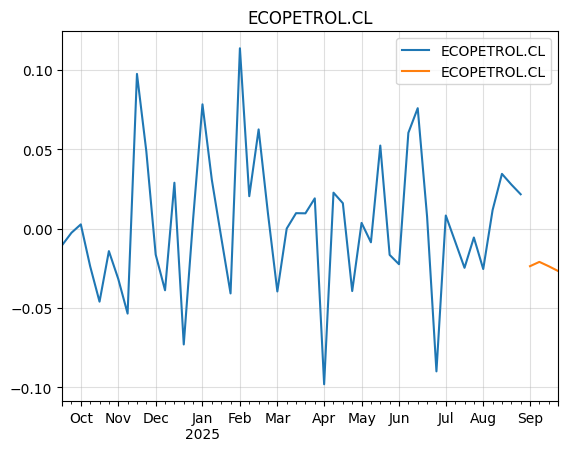

In [25]:
# Visualize the predictions of any stock
symbol = 'ECOPETROL.CL'#'PFGRUPSURA.CL'
concat_df = pd.concat([rets[symbol][-50:], preds_df[symbol]], axis=1)

concat_df.plot()
#prediction_results_processed[symbol].plot()
plt.grid(alpha=.4)
plt.title(symbol)
plt.show()

In [26]:
# Calculate the exptected annual returns for each stock
# Initialize an empty dictionary where the returns will be stored
expected_annualized_rets = {}

for symbol in preds_df.columns:
    # Calculate the weighted average returns from the predictions and then annualize them
    # Uncomment the method of weighting for the averaging and annualization of the returns
    
    ### Raw predicted returns annualized
    # expected_annualized_returns = ((prediction_results_processed[symbol] + 1).prod()**(1/len(prediction_results_processed[symbol])))**(periods_per_year) - 1
    
    ### Linearly decaying weighted returns annualized
    # weight_indexes = np.array([i+1 for i in range(periods_to_forecast)])
    # linear_decay_w = (periods_to_forecast - weight_indexes + 1)/weight_indexes.sum()
    # expected_annualized_returns = (1 + np.sum(prediction_results_processed[symbol]*linear_decay_w))**periods_per_year - 1

    ### Exponentially decaying weighted returns annualized
    weight_indexes = np.array([i+1 for i in range(periods_to_forecast)])
    lambda_ = 0.2
    exponential_decay_w = np.exp(-lambda_*weight_indexes)/np.exp(-lambda_*weight_indexes).sum()
    expected_annualized_returns = (1 + np.sum(preds_df[symbol]*exponential_decay_w))**periods_per_year - 1

    expected_annualized_rets[symbol] = expected_annualized_returns

In [27]:
# Predictions of annualized returns for the Transformer model
transformer_expected_annualized_rets = expected_annualized_rets
pd.Series(transformer_expected_annualized_rets)

BOGOTA.CL       -0.653611
BVC.CL           1.364759
CELSIA.CL       -0.197763
CEMARGOS.CL      1.719353
CIBEST.CL       -0.790816
CNEC.CL          1.597408
CONCONCRET.CL   -0.107505
CORFICOLCF.CL   -0.603831
ECOPETROL.CL    -0.723550
ENKA.CL          0.332430
ETB.CL           0.149618
EXITO.CL         0.854489
GEB.CL          -0.693046
GRUBOLIVAR.CL    3.688199
GRUPOARGOS.CL   -0.496268
GRUPOAVAL.CL     0.573542
GRUPOSURA.CL    -0.103674
HCOLSEL.CL       1.161834
ICOLCAP.CL      -0.542987
ISA.CL           0.260441
MINEROS.CL       0.909185
NUTRESA.CL       1.069923
PFAVAL.CL       -0.654211
PFCIBEST.CL     -0.635601
PFCORFICOL.CL   -0.881041
PFDAVVNDA.CL     0.135093
PFGRUPOARG.CL    2.692670
PFGRUPSURA.CL    1.623830
PROMIGAS.CL      0.329282
TERPEL.CL        3.097412
AAPL             0.247352
AMZN            -0.100631
BAC              1.397775
BRK-B            0.969699
C                0.395212
CBU7.L          -0.190491
CENCOSUD.SN      0.307544
CHILE.SN         0.749591
CSPX.L      

In [28]:
# Compare returns of different models:
"""
pd.Series(historical_annualized_returns)
pd.Series(var_bagging_expected_annualized_rets)
pd.Series(transformer_expected_annualized_rets)
"""

'\npd.Series(historical_annualized_returns)\npd.Series(var_bagging_expected_annualized_rets)\npd.Series(transformer_expected_annualized_rets)\n'

In [29]:
# Uncomment the predictions of the model that was preferred
# expected_returns = historical_annualized_returns
# expected_returns = var_bagging_expected_annualized_rets
expected_returns = transformer_expected_annualized_rets

# **Covariance matrix estimation**

## **Model 1: Historical Covariance Matrix from the last 3 years**

In [30]:
# Simple long-term covariance
covmat = rets.iloc[-periods_per_year * 3:].cov()
covmat

,BOGOTA.CL,BVC.CL,CELSIA.CL,CEMARGOS.CL,CIBEST.CL,CNEC.CL,CONCONCRET.CL,CORFICOLCF.CL,ECOPETROL.CL,ENKA.CL,ETB.CL,EXITO.CL,GEB.CL,GRUBOLIVAR.CL,GRUPOARGOS.CL,GRUPOAVAL.CL,GRUPOSURA.CL,HCOLSEL.CL,ICOLCAP.CL,ISA.CL,MINEROS.CL,NUTRESA.CL,PFAVAL.CL,PFCIBEST.CL,PFCORFICOL.CL,PFDAVVNDA.CL,PFGRUPOARG.CL,PFGRUPSURA.CL,PROMIGAS.CL,TERPEL.CL,AAPL,AMZN,BAC,BRK-B,C,CBU7.L,CENCOSUD.SN,CHILE.SN,CSPX.L,EIMI.L,F,FALABELLA.SN,GE,GOOGL,JETS,JNJ,JPM,META,NKE,NVDA,PBR,PFE,SGLD.L,VOO
BOGOTA.CL,0.001939,0.000007,0.000371,-0.000046,0.000578,0.000260,4.177749e-04,0.000678,0.000062,-0.000186,0.000037,0.000371,0.000516,0.000258,0.000209,0.000383,-0.000113,0.000280,0.000387,0.000163,0.000140,0.000226,0.000738,0.000485,0.000245,0.000386,0.000018,-0.000131,-0.000182,0.000165,0.000054,2.140237e-04,-0.000007,0.000010,0.000108,0.000064,-3.065936e-05,0.000053,0.000079,0.000217,0.000261,-0.000024,0.000200,0.000086,0.000115,0.000156,-0.000016,0.000377,0.000375,-2.083896e-04,0.000283,0.000220,0.000157,0.000051
BVC.CL,0.000007,0.001916,0.000568,0.000221,0.000072,-0.000140,-1.694355e-05,0.000188,-0.000068,0.000549,0.000304,0.000042,0.000591,0.000534,0.000273,0.000123,0.000426,0.000048,-0.000067,0.000076,0.000494,-0.000648,0.000104,0.000200,0.000218,0.000228,0.000386,0.000428,0.000628,0.000181,0.000116,7.705055e-05,-0.000087,-0.000030,-0.000014,0.000060,9.463286e-06,0.000080,0.000009,-0.000044,0.000064,-0.000059,0.000010,0.000379,-0.000118,0.000082,-0.000148,-0.000061,0.000125,-1.239126e-04,0.000041,-0.000047,0.000065,0.000030
CELSIA.CL,0.000371,0.000568,0.002053,0.000688,0.000349,0.000108,5.159424e-04,0.000585,0.000392,0.000522,0.000426,0.000511,0.001102,0.001094,0.000954,0.000079,0.000713,0.000366,0.000430,0.000258,0.000689,-0.000766,0.000121,0.000513,0.000638,0.000944,0.000986,0.001230,0.000619,0.000298,0.000015,2.990646e-05,0.000171,0.000022,0.000243,0.000027,-8.091599e-05,0.000021,0.000117,0.000172,0.000296,-0.000171,0.000269,0.000313,0.000073,0.000019,0.000133,0.000294,0.000150,2.581526e-04,0.000061,-0.000060,0.000252,0.000131
CEMARGOS.CL,-0.000046,0.000221,0.000688,0.002876,0.000252,-0.000069,5.364954e-04,0.000312,0.000368,0.000140,0.000488,-0.000381,0.000633,0.000159,0.001106,-0.000076,0.000848,0.000257,0.000325,0.000449,0.000655,-0.000817,0.000012,0.000158,0.000775,0.000536,0.000869,0.000896,0.000692,0.000186,-0.000092,-4.301813e-05,0.000174,0.000066,0.000274,0.000027,-2.807536e-05,-0.000050,0.000122,0.000019,0.000202,-0.000090,-0.000059,0.000166,0.000008,0.000108,0.000124,-0.000018,0.000162,-4.891700e-05,-0.000035,-0.000050,0.000163,0.000077
CIBEST.CL,0.000578,0.000072,0.000349,0.000252,0.002017,0.000256,3.864738e-04,0.000819,0.000398,0.000419,0.000142,0.000219,0.000308,0.000402,0.000722,0.000441,0.000316,0.000507,0.000753,0.000720,0.000265,0.000354,0.000792,0.001314,0.000632,0.000629,0.000649,0.000556,0.000146,0.000381,-0.000048,-9.514803e-05,0.000279,0.000118,0.000464,0.000048,2.964825e-05,0.000240,0.000072,0.000306,0.000568,0.000061,0.000101,-0.000051,0.000138,0.000093,0.000220,-0.000014,0.000352,-3.318689e-04,0.000192,0.000076,0.000097,0.000047
CNEC.CL,0.000260,-0.000140,0.000108,-0.000069,0.000256,0.005618,2.185695e-05,0.000029,0.000964,-0.000115,0.000091,-0.000084,-0.000034,0.000078,-0.000006,0.000266,-0.000339,0.000132,0.000275,-0.000052,0.000284,0.000110,0.000286,0.000351,-0.000159,0.000107,0.000054,-0.000009,-0.000204,0.000201,0.000335,2.107874e-04,0.000519,0.000245,0.000432,-0.000002,9.951882e-05,-0.000068,0.000149,0.000287,0.000653,0.000189,0.000560,0.000407,0.000247,-0.000045,0.000459,0.000017,0.000186,1.836829e-04,0.000684,0.000040,0.000154,0.000209
CONCONCRET.CL,0.000418,-0.000017,0.000516,0.000536,0.000386,0.000022,4.548787e-03,0.000792,0.000454,0.000258,0.000674,0.000562,0.000727,0.000344,0.000521,0.000429,0.000445,0.000224,0.000472,0.000125,0.000362,-0.000142,0.000447,0.000349,0.000594,0.000516,0.000421,0.000844,0.000229,0.000109,-0.000012,7.675266e-07,0.000257,-0.000185,0.000340,-0.000075,1.072061e-04,0.000182,0.000036,0.000052,-0.000011

## **Model 2: Multivariate GARCH**

In [31]:
summary_stats = rk.summary_stats(rets[selected_stocks], periods_per_year=periods_per_year, riskfree_rate=0)
returns = summary_stats['Annualized Return']

# Recent covariance prediction based on recent days with GARCH model
vol = mgarch('t')
vol.fit(rets[selected_stocks])
nperiods = 4
covmat = vol.predict(nperiods)
covmat = pd.DataFrame(data=covmat['cov'], index=returns.index, columns=returns.index)

# **Export predicted returns and covariance matrix**

In [32]:
pd.Series(expected_annualized_rets)[selected_stocks].to_csv('expected_returns.csv', header=None)

In [33]:
covmat.to_csv('expected_covmat.csv')